In [1]:
import numpy as np
import pandas as pd
import io
import requests
import re
import warnings
import os
print(os.listdir("../input"))
import sklearn
import xgboost as xgb

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.svm import SVC

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

['titanic', 'gender-submisson', 'test-file']


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/gender-submisson/All 1.csv
/kaggle/input/test-file/tested.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# Print train and test columns
test = pd.read_csv("../input/titanic/test.csv")
train = pd.read_csv("../input/titanic/train.csv")
print('Train columns:', train.columns.tolist())
print('Test columns:', test.columns.tolist())

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Test columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [5]:
#This is test file from titanic and gender_submission combined
tested = pd.read_csv("../input/test-file/tested.csv")
tested.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
PassengerId = test['PassengerId']
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3])
train['Ticket_type'] = train['Ticket_type'].astype('category')
train['Ticket_type'] = train['Ticket_type'].cat.codes

test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

In [7]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values 

# Gender

In [8]:
gender_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
gender_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [9]:
gender = pd.read_csv("../input/titanic/gender_submission.csv")
print('Gender columns:', gender.columns.tolist())

Gender columns: ['PassengerId', 'Survived']


In [10]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


**Women and children** were the first to board the titanic which means they are more likely to survive than men

In [11]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


# Age

The younger you are the more likely to survive

In [12]:
data = [train_data, test_data]
for dataset in data:
    mean = train_data["Age"].mean()
    std = test_data["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)

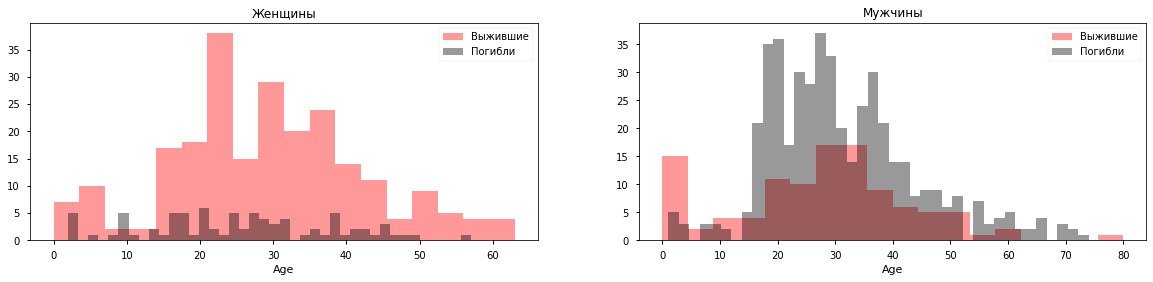

In [13]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 4))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = "Выжившие", ax = axes[0], kde =False, color="red")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = "Погибли", ax = axes[0], kde =False, color="black")
ax.legend()
ax.set_title('Женщины')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = "Выжившие", ax = axes[1], kde = False, color="red")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = "Погибли", ax = axes[1], kde = False, color="black")
ax.legend()
_ = ax.set_title('Мужчины');

In [14]:
df = pd.read_csv('../input/titanic/train.csv')
fig = px.scatter_3d(df, x='PassengerId', y='Sex', z='Age',
                    color='Age')
fig.show()

In [15]:
df = pd.read_csv('../input/test-file/tested.csv')

for template in ["plotly"]:
    fig = px.scatter(df,
                     x="PassengerId", y="Age", color="Survived",
                     log_x=True, size_max=20,
                     template=template, title="Какой возраст спася?")
    fig.show()

# Вывод
 **1. Женщина возрастом 72 года в любом случае спасается .**